# col cuore in gola

In [ ]:
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO
import json
import pickle
import matplotlib.pyplot as plt
import re
from collections import Counter

## fine tuning

In [ ]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from datasets import load_dataset
import datasets

In [ ]:
import torch
torch.cuda.get_device_name(0)

- https://github.com/rafalposwiata/depression-detection-lt-edi-2022

dataset

In [ ]:
data_text = ""

for filename in sorted(["ds", "ts_hs", "ts_ht"]):
    with open(Path("datasets", "task_0", f"{filename}.tsv"), "rt", encoding="utf8") as f:
        data_text += f.read()

df = pd.read_csv(StringIO(data_text), sep="\t")
# dup_idx = df.index.difference(df.drop_duplicates().index)
# df.loc[dup_idx]
df = df.drop_duplicates().reset_index(names="old_idx").reset_index(names="new_idx")

train test indexes

In [ ]:
lookup = df.set_index("old_idx")["new_idx"]
pth = Path("datasets", "task_0", "train_test_splitting.json")
idx = json.load(open(pth, "rt"))
idx = {k: [lookup[i] for i in lst if i in lookup] for k, lst in idx.items()}


In [ ]:
x, y = df["pp_text"], df["label"]
x_train, x_test = x.loc[idx["train"]], x.loc[idx["test"]]
y_train, y_test = y.loc[idx["train"]], y.loc[idx["test"]]

In [ ]:
dataset = {
    "train": datasets.Dataset.from_list([{"label": int(y), "text": str(x)} for y, x in zip(y_train, x_train)]),
    "test": datasets.Dataset.from_list([{"label": int(y), "text": str(x)} for y, x in zip(y_test, x_test)]),
}

dataset =  datasets.DatasetDict(dataset)

tokens

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ShreyaR/finetuned-roberta-depression")

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
tokenized_datasets.items()

In [ ]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

finetuning

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("ShreyaR/finetuned-roberta-depression") # "rafalposwiata/deproberta-large-depression"

In [ ]:
training_args = TrainingArguments(
    "test-trainer",
    # no_cuda=True,
    seed=42,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
)


In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["eval"],
    # data_collator=data_collator, 
    # tokenizer=tokenizer,
)

In [ ]:
# trainer.train()
# predictions = trainer.predict(tokenized_datasets["test"])

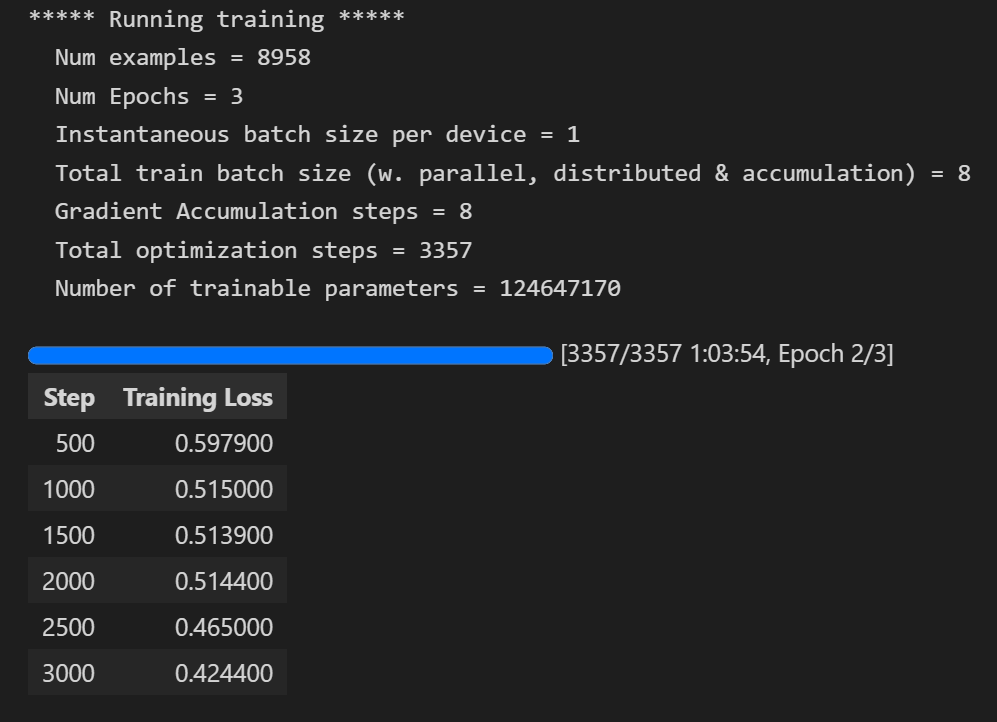

In [ ]:
dataset["test"][-1], dataset["test"][0]

metrics

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
y_fine = pickle.load(open("predictions/fine.pkl", "rb"))
y_raw = pickle.load(open("predictions/raw.pkl", "rb"))

In [ ]:
y_true = y_raw[1]

In [ ]:
y_fine = [ 1 if p < n else 0 for p, n in y_fine[0]]
y_raw = [ 1 if p < n else 0 for p, n in y_raw[0]]

In [ ]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_raw)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

In [ ]:
print('Precision:', precision_score(y_true, y_raw))
print('Recall: ', recall_score(y_true, y_raw))
print('Accuracy: ',  accuracy_score(y_true, y_raw))
print('F1 Score: ',  f1_score(y_true, y_raw))

In [ ]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_fine)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

In [ ]:
print('Precision:', precision_score(y_true, y_fine))
print('Recall: ', recall_score(y_true, y_fine))
print('Accuracy: ',  accuracy_score(y_true, y_fine))
print('F1 Score: ',  f1_score(y_true, y_fine))

In [ ]:
group = [ ]
for i, v in enumerate(zip(y_fine, y_true)):
    match v:
        case (0,0):
            group.append("TN")
        case (1,1):
            group.append("TP")
        case (0,1):
            group.append("FN")
        case (1,0):
            group.append("FP")
        case _:
            raise ValueError("!")            

In [ ]:
Counter(group)

## what models do?

tf idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.spatial import distance

In [ ]:
vect = TfidfVectorizer()
tfidf_mx = vect.fit_transform(x_test)
words = vect.get_feature_names_out()

In [ ]:
type(tfidf_mx)

In [ ]:
a, b = tfidf_mx.shape
tiv = np.zeros((a,b))
for i in tqdm(range(a)):
    for j in range(b):
        tiv = tfidf_mx[i,j]

In [ ]:
# cosine_tfidf = np.array([ [ distance.cosine(tmp[i],tmp[j]) for i in range(a)] for i in tqdm(range(a))])

sintactic

In [ ]:
def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

In [ ]:
import liwc
parse, category_names = liwc.load_token_parser('dic/LIWC.dic')

In [ ]:
K = len(category_names)
N = len(x_test)

kat_lookup = dict(zip(category_names, range(K)))

In [ ]:
kat_freq = np.zeros((N, K))
for n, text in enumerate(x_test):
    for t in tokenize(text):
        for m in parse(t):
            k = kat_lookup[m]
            kat_freq[n,k] += 1

In [ ]:
cosine_mx = np.zeros((N,N))
for i in tqdm(range(N)):
    for j in range(N):
        cosine_mx[i,j] = distance.cosine(kat_freq[i], kat_freq[j])

In [ ]:
# THRESHOLD = 0.5
# np.sign(cosine_mx - THRESHOLD)

In [ ]:
NC = 3

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=NC, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(cosine_mx)
X_embedded.shape


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=NC)
new_coord = pca.fit_transform(cosine_mx)


In [ ]:
import plotly.express as px

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    new_coord, # X_embedded,
    labels=labels,
    dimensions=range(NC),
    color=group,
    height=1000,
)
fig.update_traces(diagonal_visible=False)
fig.show()